# GAN

## Import Libraries and Define Constants

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import pandas as pd
from datasets import EmnistDataset, EmnistMapping, emnist_transform, augmentations, FontDataset, font_transform
from config import EMNIST_TRAIN_PATH, EMNIST_TEST_PATH, EMNIST_MAPPING_PATH, FONTS_DATASET_PATH, FONTS_MAPPING_PATH

# Define constants
batch_size = 64 * 1
image_size = 28
nz = 100  # Size of z latent vector (i.e., size of generator input)
num_epochs = 1000
lr = 0.0002
beta1 = 0.5
lambda_gp = 5  # Gradient penalty lambda
n_classes = 47  # Number of classes in EMNIST balanced split
device = 'cuda' if torch.cuda.is_available() else "cpu"


## Load data

In [62]:
# dataset = EmnistDataset(EMNIST_TRAIN_PATH, augmentations, limit=256)
dataset = FontDataset(FONTS_DATASET_PATH, FONTS_MAPPING_PATH, font_transform)
mapping = EmnistMapping(EMNIST_MAPPING_PATH)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [58]:
# Validate DataLoader
for images, labels in dataloader:
    print(images.shape)  # Should be [batch_size, 1, 28, 28]
    print(labels.shape)  # Should be [batch_size]
    break  # Exit after printing the first batch

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [5]:
def print_tensor_stats(tensor, name):
    print(f"{name}: min={tensor.min().item()}, max={tensor.max().item()}, mean={tensor.mean().item()}, std={tensor.std().item()}")

In [59]:
print_tensor_stats(dataset[0][0],"grfgd")

grfgd: min=-1.0, max=1.0, mean=-0.6653761863708496, std=0.6649017333984375


In [7]:
def show_image(image, mapping=None, title=None):
    # Create a figure with subplots in a grid
    fig, ax = plt.subplots(figsize=(3, 3))

    ax.imshow(image[0][0].numpy(), cmap='gray')
    # ax.set_title(mapping[image[1].item()])
    ax.axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()


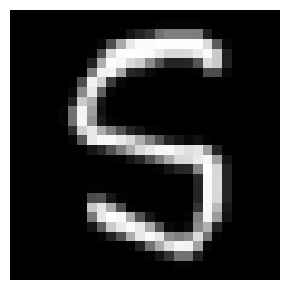

tensor(28)


In [60]:
show_image(dataset[9])
print(dataset[9][1])

## Define the Generator and Critic

In [9]:
class ConditionalGenerator(nn.Module):
    def __init__(self, nz, n_classes, ngf, nc):
        super(ConditionalGenerator, self).__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz + n_classes, ngf * 8, 4, 1, 0, bias=False),
            nn.InstanceNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 2, bias=False),
            nn.InstanceNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 1, 1, 0, bias=False),  # Adjusted padding
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embeddings = self.label_emb(labels).view(labels.size(0), -1, 1, 1)
        gen_input = torch.cat((noise, label_embeddings), 1)
        return self.main(gen_input)

class ConditionalCritic(nn.Module):
    def __init__(self, nc, ndf, n_classes):
        super(ConditionalCritic, self).__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.main = nn.Sequential(
            nn.Conv2d(nc + n_classes, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 2, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 2, 1, 0, bias=False),
        )


    def forward(self, img, labels):
        label_embeddings = self.label_emb(labels).view(labels.size(0), -1, 1, 1)
        label_embeddings = label_embeddings.repeat(1, 1, img.size(2), img.size(3))
        d_input = torch.cat((img, label_embeddings), 1)
        return self.main(d_input).view(-1, 1).squeeze(1)


## Initialize the Models

In [50]:
# Number of channels in the training images. For grayscale images, this is 1
nc = 1
# Size of feature maps in generator
ngf = 64 * 4
# Size of feature maps in discriminator
ndf = 64 * 4

netG = ConditionalGenerator(nz, n_classes, ngf, nc).to(device)
netD = ConditionalCritic(nc, ndf, n_classes).to(device)


In [51]:
# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

ConditionalCritic(
  (label_emb): Embedding(47, 47)
  (main): Sequential(
    (0): Conv2d(48, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(2048, 1, kernel_size=(2, 2), stride=(1, 1), bias=False)
  )
)

## Define the Loss Function and Optimizers

In [52]:
criterion = nn.BCEWithLogitsLoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training Loop

In [55]:
gen_upd_rate = 2
image_show_rate = 256
loss_show_rate = 256
epoch_show_rate = 10

In [63]:
for epoch in range(num_epochs):
    for i, (data, labels) in enumerate(dataloader, 0):
        batch_size = data.size(0)

        # Train Critic
        netD.zero_grad()
        real_data = data.to(device)
        real_labels = labels.to(device)

        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_labels = torch.randint(0, n_classes, (batch_size,), device=device)
        fake_data = netG(noise, fake_labels)

        real_target = torch.ones(batch_size, device=device)
        fake_target = torch.zeros(batch_size, device=device)

        d_real_loss = criterion(netD(real_data, real_labels), real_target)
        d_fake_loss = criterion(netD(fake_data.detach(), fake_labels), fake_target)
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        optimizerD.step()

        # Train Generator
        if i % gen_upd_rate == 0:
            netG.zero_grad()
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_labels = torch.randint(0, n_classes, (batch_size,), device=device)
            fake_data = netG(noise, fake_labels)
            g_loss = criterion(netD(fake_data, fake_labels), real_target)
            g_loss.backward()
            optimizerG.step()

        if i % loss_show_rate == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(dataloader)}] '
                f'Loss D: {d_loss.item()}, Loss G: {g_loss.item()}')

        if (i % image_show_rate == 0) and ((epoch + 1) % epoch_show_rate == 0):
            with torch.no_grad():
                fixed_noise = torch.randn(64, nz, 1, 1, device=device)
                fixed_labels = torch.randint(0, n_classes, (64,), device=device)
                generated_images = netG(fixed_noise, fixed_labels)
                # Save or visualize the generated images using Matplotlib or TensorBoard
                # Example using Matplotlib:
                plt.figure(figsize=(8, 8))
                for j in range(64):
                    plt.subplot(8, 8, j + 1)
                    plt.imshow(generated_images[j].squeeze().cpu().numpy(), cmap='gray')
                    plt.axis('off')
                plt.tight_layout()
                plt.savefig(f'generated_images/fonts5_epoch_{epoch+1}_batch_{i}.png')
                plt.close()

Epoch [1/1000] Batch [0/23] Loss D: 12.267582893371582, Loss G: 0.256841242313385


Epoch [2/1000] Batch [0/23] Loss D: 0.00035611900966614485, Loss G: 11.995532035827637
Epoch [3/1000] Batch [0/23] Loss D: 0.656411349773407, Loss G: 17.363399505615234
Epoch [4/1000] Batch [0/23] Loss D: 1.180397868156433, Loss G: 13.890617370605469
Epoch [5/1000] Batch [0/23] Loss D: 0.03047582134604454, Loss G: 9.911396026611328
Epoch [6/1000] Batch [0/23] Loss D: 0.006901036482304335, Loss G: 3.1025161743164062
Epoch [7/1000] Batch [0/23] Loss D: 0.032247986644506454, Loss G: 10.04847526550293
Epoch [8/1000] Batch [0/23] Loss D: 0.14657720923423767, Loss G: 5.787108898162842
Epoch [9/1000] Batch [0/23] Loss D: 0.05167573690414429, Loss G: 6.960891246795654
Epoch [10/1000] Batch [0/23] Loss D: 0.16183623671531677, Loss G: 5.349616050720215
Epoch [11/1000] Batch [0/23] Loss D: 0.012616629712283611, Loss G: 10.366363525390625
Epoch [12/1000] Batch [0/23] Loss D: 0.004697762429714203, Loss G: 7.719142436981201
Epoch [13/1000] Batch [0/23] Loss D: 0.04911820963025093, Loss G: 6.78813362

KeyboardInterrupt: 

## Sample symbols

In [69]:
import os

def generate_gan_symbols(symbols, amount):
    dataset = pd.DataFrame(columns=['path', 'label'])
    os.makedirs("data/GAN weak/data", exist_ok=True)
    with torch.no_grad():
        for symbol in symbols:
            symbol_class = mapping.unmapping[symbol]
            labels = torch.full((amount,), symbol_class, device=device)
            noise = torch.randn(amount, nz, 1, 1, device=device)
            generated_images = netG(noise, labels)

            # Save the generated images as PNG files
            for i in range(amount):
                image_path = f"data/GAN weak/data/{symbol}_{i}.png"
                vutils.save_image(generated_images[i], image_path, normalize=True)
                dataset.loc[len(dataset)] = [f"data/GAN weak/data/{symbol}_{i}.png", symbol]
    return dataset

In [70]:
symbols = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'
# symbols = "a"
df = generate_gan_symbols(symbols, 2)
df.head()

,path,label
0,data/GAN weak/data/0_0.png,0
1,data/GAN weak/data/0_1.png,0
2,data/GAN weak/data/1_0.png,1
3,data/GAN weak/data/1_1.png,1
4,data/GAN weak/data/2_0.png,2


In [45]:
df.to_csv("data/GAN/dataset.csv", index=False)